In [9]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [5]:
full_df = pd.read_csv("../data/processed/full_df.csv")
full_df['tokens'] = full_df['tokens'].apply(ast.literal_eval)
full_df['tokens_str'] = full_df['tokens'].apply(lambda x:" ".join(x))
#subject_start = full_df['cleaned_body'].str.startswith('subject')

#full_df.loc[subject_start, 'cleaned_body'] = full_df.loc[subject_start, 'cleaned_body'].apply(
#    lambda x: x[len('subject'):].lstrip()
#)
# Display them
#print(full_df['cleaned_body'].str.startswith('subject').sum()) 

In [17]:
bow_vectorizer = CountVectorizer(stop_words='english', max_features= 10000, min_df=4, ngram_range =(1,3),token_pattern=r'\b[a-zA-Z]{3,15}\b')
X_bow = bow_vectorizer.fit_transform(full_df['tokens_str'])
print(X_bow.shape)
bow_features = bow_vectorizer.get_feature_names_out()


(125981, 10000)


In [20]:
bow_counts = np.asarray(X_bow.sum(axis=0)).flatten()
bow_freq = pd.Series(bow_counts, index=bow_features).sort_values(ascending=False)
print(bow_freq.head(20))


email          63449
enron          62766
new            56920
time           50899
list           48653
company        47873
ect            44992
message        42647
like           42111
use            40830
need           38119
price          37799
information    37782
work           36379
subject        35588
make           35334
know           34813
day            33685
business       31772
file           31543
dtype: int64


In [21]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_features=10000,min_df=4,ngram_range=(1, 3),token_pattern=r'\b[a-zA-Z]{3,15}\b')
X_tfidf = tfidf_vectorizer.fit_transform(full_df['tokens_str'])
tfidf_features = tfidf_vectorizer.get_feature_names_out()

tfidf_sum = np.asarray(X_tfidf.sum(axis=0)).flatten()

tfidf_scores = pd.Series(tfidf_sum, index = tfidf_features).sort_values(ascending=False)

print(tfidf_scores.head(20))
tfidf_scores.sample(30)

email      2172.480473
list       1805.564796
new        1591.533585
like       1576.961774
time       1569.775788
price      1546.244460
enron      1532.798544
watch      1507.757813
message    1477.177197
wrote      1468.722953
need       1409.794924
use        1400.937752
know       1390.764722
work       1326.971547
day        1323.919304
ect        1312.619413
com        1298.263214
file       1295.266338
thanks     1284.863410
mailing    1278.575784
dtype: float64


disounts offering imited        40.876941
studio adobe                    24.332062
powerful                       138.873351
giant                           50.614338
fit                            193.343023
inclusive                       33.638256
couid                           12.764732
php                            166.639296
dispatch                        34.399775
viagra cialis                   74.070283
diabetes                        21.615759
prove                           97.740612
archive nabblecom mailing       52.027682
sold                           162.119914
whalley                         27.093183
forecast beverly hill           30.063398
estimation                      29.942409
enron communication             84.345158
hub                             30.233833
vip customer case               16.431740
husband                        180.311118
phrase                          54.936167
wet                             36.445552
environmental                   43

In [25]:
combined_features = pd.concat([bow_freq, tfidf_scores], axis = 1)

combined_features.columns = ['BoW Frequency', 'TF-IDF Score']

combined_features = combined_features.sort_values(by='BoW Frequency', ascending=False)
combined_features.to_csv('../data/processed/combined_features_bow_tfidf.csv')
print(combined_features.head(20))



             BoW Frequency  TF-IDF Score
email                63449   2172.480473
enron                62766   1532.798544
new                  56920   1591.533585
time                 50899   1569.775788
list                 48653   1805.564796
company              47873   1087.975781
ect                  44992   1312.619413
message              42647   1477.177197
like                 42111   1576.961774
use                  40830   1400.937752
need                 38119   1409.794924
price                37799   1546.244460
information          37782   1127.401102
work                 36379   1326.971547
subject              35588   1247.114699
make                 35334   1228.453341
know                 34813   1390.764722
day                  33685   1323.919304
business             31772    920.140861
file                 31543   1295.266338


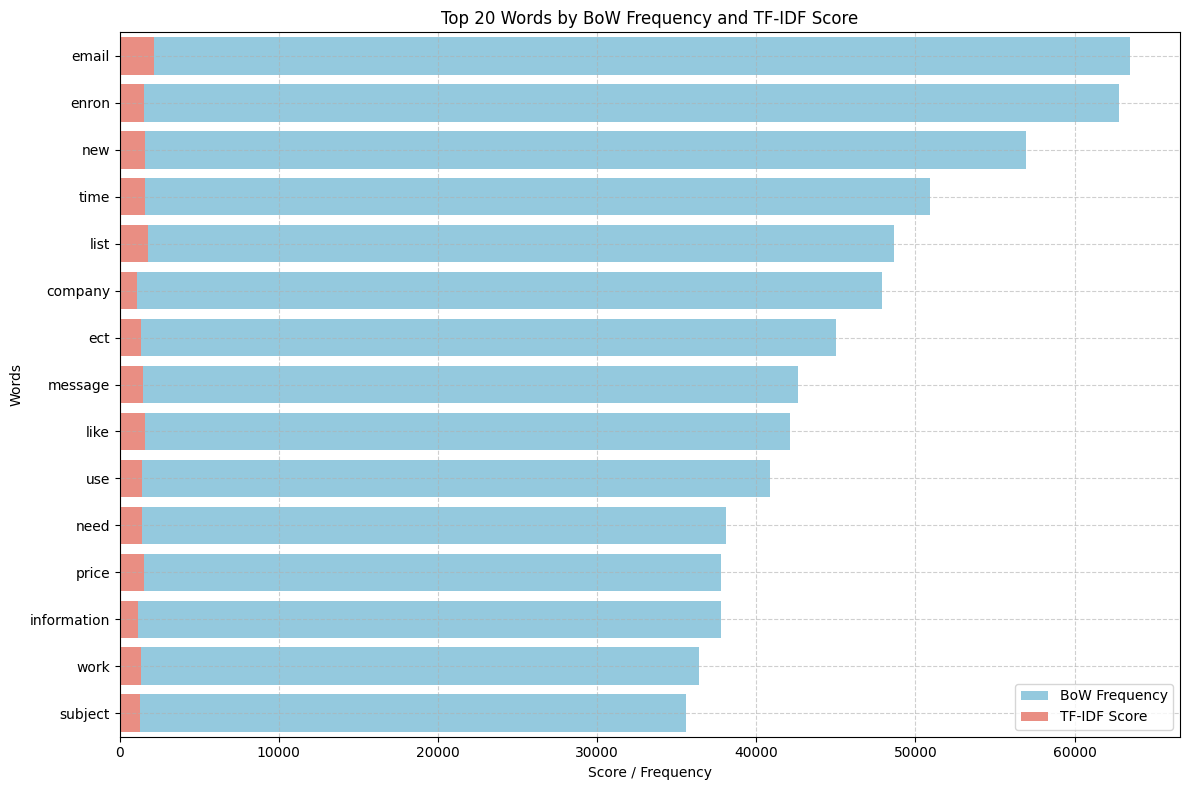

In [31]:
top_n = 15  
top_words = combined_features.head(top_n)

plt.figure(figsize=(12, 8))

sns.barplot(
    x=top_words['BoW Frequency'],
    y=top_words.index,
    color='skyblue',
    label='BoW Frequency'
)

sns.barplot(
    x=top_words['TF-IDF Score'],
    y=top_words.index,
    color='salmon',
    label='TF-IDF Score'
)

plt.title('Top 20 Words by BoW Frequency and TF-IDF Score')
plt.xlabel('Score / Frequency')
plt.ylabel('Words')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

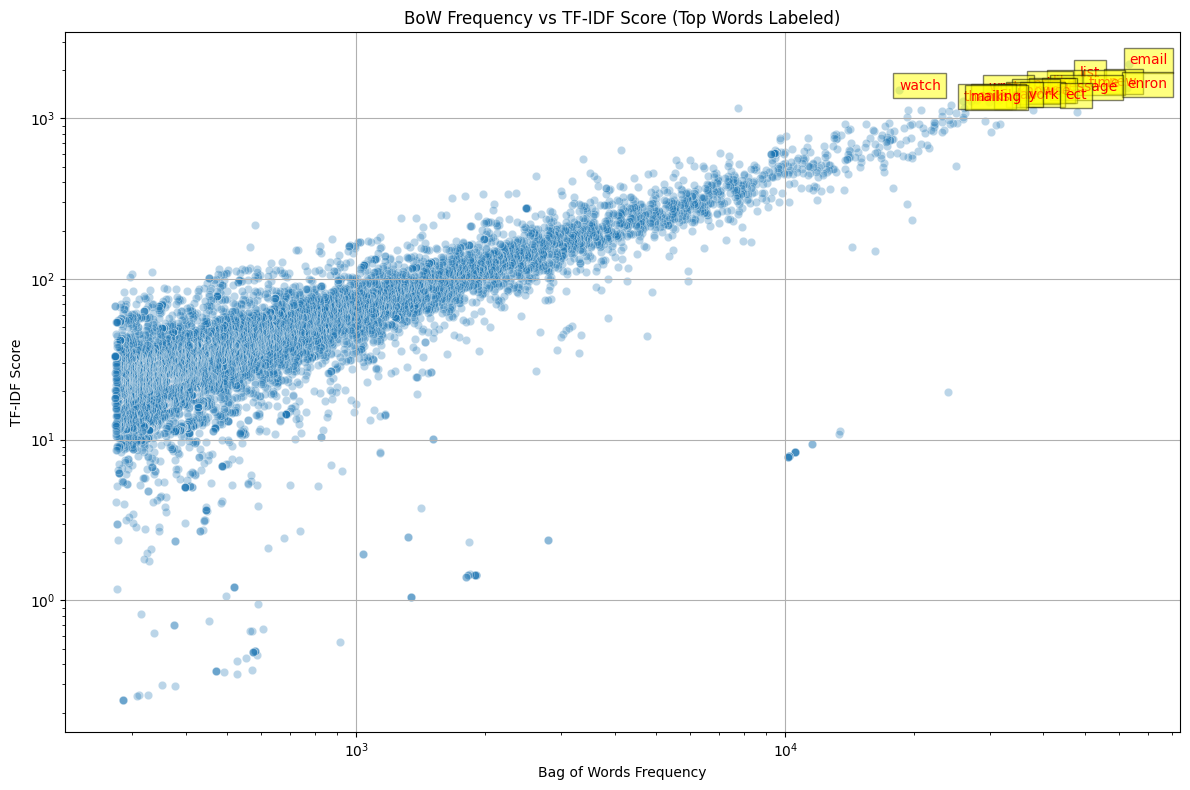

In [32]:
top_words = combined_features.sort_values(by='TF-IDF Score', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_features,
    x='BoW Frequency',
    y='TF-IDF Score',
    alpha=0.3
)

for i in range(top_words.shape[0]):
    plt.text(
        x=top_words['BoW Frequency'].iloc[i],
        y=top_words['TF-IDF Score'].iloc[i],
        s=top_words.index[i],
        fontdict=dict(color='red', size=10),
        bbox=dict(facecolor='yellow', alpha=0.5)
    )

plt.title('BoW Frequency vs TF-IDF Score (Top Words Labeled)')
plt.xlabel('Bag of Words Frequency')
plt.ylabel('TF-IDF Score')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
label = full_df['label']
data = {'X_bow': X_bow, 'X_tfidf': X_tfidf, 'label': label, 'bow_vectorizer': bow_vectorizer, 'tfidf_vectorizer': tfidf_vectorizer}

with open('../Models/engineered_features_bow_tfidf.pkl', 'wb') as f:
    pickle.dump(data,f)